# Introduzione

## Descrizione del dataset
https://osf.io/vnbxk/overview
Il dataset analizza un campione di gamer internazionali e raccoglie informazioni psicologiche, demografiche e comportamentali.
Le variabili principali si suddividono in tre categorie:

Indicatori psicologici: risposte ai questionari GAD-7 (ansia), SPIN (fobia sociale) e SWL (soddisfazione di vita), da cui sono stati calcolati i punteggi totali GAD_T, SPIN_T e SWL_T.

Comportamento di gioco: informazioni su gioco preferito (Game), piattaforma (Platform), ore di gioco settimanali (Hours), motivazioni (whyplay), livello competitivo (highestleague) e stile di gioco (Playstyle).

Dati demografici: età (Age), genere (Gender), titolo di studio (Degree), occupazione (Work), paese di nascita e residenza.

La variabile target scelta per l’analisi è SWL_T (Satisfaction With Life Total Score), mentre le altre variabili vengono utilizzate come predittori nel modello di regressione.

### Fattori psicologici
GAD (Generalized Anxiety Disorder)
- GAD1 - GAD7: Individual question scores on the GAD-7 questionnaire
- GAD_T: Total GAD score (0–21)

SWL (Satisfaction With Life)
- SWL1 - SWL5: Individual question scores on the SWL questionnaire
- SWL_T: Total SWL score (5–35)

SPIN (Social Phobia Inventory)
- SPIN1 - SPIN17: Individual question scores on the SPIN questionnaire
- SPIN_T: Total SPIN score (0–68)


## Note
Il dataset è stato pubblicato il 30 ottobre 2017. Le modalità di gioco e le suddivisioni [ELO](https://it.wikipedia.org/wiki/Elo_(scacchi)) sono mutate nel corso degli anni. In questo documento si fa analisi considerando le suddivisioni di quando i dati sono stati raccolti.

# Cleanup del dataset

In [137]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
dataset = pd.read_csv("GamingStudy_data.csv")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13464 entries, 0 to 13463
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   S. No.           13464 non-null  int64  
 1   Timestamp        13464 non-null  float64
 2   GAD1             13464 non-null  int64  
 3   GAD2             13464 non-null  int64  
 4   GAD3             13464 non-null  int64  
 5   GAD4             13464 non-null  int64  
 6   GAD5             13464 non-null  int64  
 7   GAD6             13464 non-null  int64  
 8   GAD7             13464 non-null  int64  
 9   GADE             12815 non-null  object 
 10  SWL1             13464 non-null  int64  
 11  SWL2             13464 non-null  int64  
 12  SWL3             13464 non-null  int64  
 13  SWL4             13464 non-null  int64  
 14  SWL5             13464 non-null  int64  
 15  Game             13464 non-null  object 
 16  Platform         13464 non-null  object 
 17  Hours       

In [138]:
print("Numero di colonne con valori mancanti: ", dataset.isna().any().sum())
print("Numero di valori mancanti per colonna:")
dataset.isna().sum()[dataset.isna().sum() > 0]

Numero di colonne con valori mancanti:  30
Numero di valori mancanti per colonna:


GADE                 649
Hours                 30
League              1852
highestleague      13464
streams              100
SPIN1                124
SPIN2                154
SPIN3                140
SPIN4                159
SPIN5                166
SPIN6                156
SPIN7                138
SPIN8                144
SPIN9                158
SPIN10               160
SPIN11               187
SPIN12               168
SPIN13               187
SPIN14               156
SPIN15               147
SPIN16               147
SPIN17               175
Narcissism            23
Work                  38
Degree              1577
Reference             15
accept               414
SPIN_T               650
Residence_ISO3       110
Birthplace_ISO3      121
dtype: int64

La colonna 'highestleague' non contiene nessun valore quindi è possibile eliminarla. 'streams' non contiene valori utili ai fini dell'analisi

In [139]:
dataset.drop(columns=['highestleague', 'streams'], inplace=True)
dataset.dropna(subset=['SPIN_T'], inplace=True)
dataset.drop(['S. No.' , 'Timestamp'] , axis = 1 , inplace = True)

In [140]:
print("Elementi duplicati: ", dataset.duplicated().sum())
dataset = dataset.drop_duplicates()
print("Elementi duplicati dopo rimozione: ", dataset.duplicated().sum())

Elementi duplicati:  49
Elementi duplicati dopo rimozione:  0


### Scelta di gioco

In [141]:
print("Giochi distinti:", dataset['Game'].dropna().unique())
# counts for each value (shows NaN count if any)
print("\nConteggio dei valori per gioco (inclusi NaN):")
print(dataset['Game'].value_counts(dropna=False))

Giochi distinti: ['Skyrim' 'Other' 'World of Warcraft' 'League of Legends' 'Starcraft 2'
 'Counter Strike' 'Destiny' 'Diablo 3' 'Heroes of the Storm' 'Hearthstone'
 'Guild Wars 2']

Conteggio dei valori per gioco (inclusi NaN):
Game
League of Legends      10731
Other                    970
Starcraft 2              322
Counter Strike           298
World of Warcraft        149
Hearthstone               95
Diablo 3                  83
Heroes of the Storm       40
Guild Wars 2              36
Skyrim                    23
Destiny                   18
Name: count, dtype: int64


Il gioco dominante del dataset è *League of Legends*. Poiché le modalità di gioco (competitività, categoria...) influiscono sui fattori psicologici e la sproporzione di risposte non consenta un'analisi approfondita, si considera la sola valutazione dei dati relativi a *League of Legends*

In [142]:
lol_dataset = dataset[dataset['Game'] == 'League of Legends'].copy()

## Cleanup dei ranghi (League)

In [143]:
lol_dataset.League = lol_dataset.League.str.lower().str.strip()
# Prende la prima parola
lol_dataset["League"] = lol_dataset["League"].str.extract(r'^([a-z]+)')
print(lol_dataset["League"].value_counts().head(50))
print(lol_dataset["League"].nunique())


League
gold           2648
silver         1946
platinum       1556
diamond        1265
plat            503
bronze          466
unranked        455
master           81
platin           77
platinium        64
challenger       58
d                39
not              34
s                26
g                25
none             18
platnium         17
placements       15
i                12
currently        10
masters          10
p                10
dia               9
sliver            8
b                 8
challenjour       8
still             6
unraked           6
was               6
season            5
high              5
haven             5
platine           5
na                4
don               4
platium           4
no                4
league            3
placement         3
lol               3
golf              3
last              3
plarinum          3
wood              3
n                 3
peaked            2
bronce            2
platnum           2
in                2
got          

In [144]:
golds = ['g', 'gv', 'golden' ,'glod' ,'golld' ,'golf', 'goled', 'golderino' ,'giii']
lol_dataset['League'] = lol_dataset.League.replace(golds , 'gold')
silvers = [ 'silverii' , 's' , 'sliver' , 'siver' , 'silber' , 'sil' , 'silveriv']
lol_dataset['League'] = lol_dataset.League.replace(silvers , 'silver')
plats = [
    'platinium' , 'platnium' , 'platin' ,'pplatinum' ,'plarinum' ,'platium', 'p' ,'platine' ,
    'platinun' ,'platonum' ,'platnum', 'plata' ,'plantinum',
    'platinuim' ,'platunum', 'plantinum' ,'platunum' ,'platinumm' ,'platv' ,'platina' , 'plat' 
]
lol_dataset['League'] = lol_dataset.League.replace(plats , 'platinum')
bronzers = ['bronce' , 'b' , 'broze' ,'lowest' , 'wood', 'elohell'] 
lol_dataset['League'] = lol_dataset.League.replace(bronzers , 'bronze')
unranked = ['none' ,'na', 'not' ,'n' ,'promos' ,'provisional' ,'placements' , 'dont' , 'was', 'unraked',
            'havent', 'never', 'nope', 'no', 'noone', 'don', 'of', 'unrranked', 'new', 'what', 'unrank' ,
            'ranked', 'placement', 'unrankt' , 'non', 'unfranked' , 'promotion', 'idk',
            'unplaced', 'probably', 'provisionals', 'didnt' ,'unrakned' , 'unfinished' , 'just' , 'x' ,
            'promotions' , 'unseeded' , 'haven', 'uwot', 'spanish', 'around', 'finishing', 'ahgl','i', 'currently', 'still', 'high', 'season', 'lol', 'last', 'league', 'got', 'the', 'peaked', 'in', 'atm', 'were', 'ex', 'finished', 'will', 'climbing', 'yes', 'csgo', 'unable', 'under', 'having', 'if', 'level', 'lissandra', 'north', 'low', 'ended', 'doing', 'pre', 'zilean', 'aram', 'lvl', 'current', 'first', 'recently', 'challenged', 'soloq', 'cardboard', 'seaon', 'almost', 'legendary', 'german', 'placed', 'un', 'eu', 'qualifiying', 'euw']
lol_dataset['League'] = lol_dataset.League.replace(unranked , 'unranked')
diamonds =  ['d', 'dia', 'diaomnd', 'diamont','diamomd']
lol_dataset['League'] = lol_dataset.League.replace(diamonds , 'diamond')
gm =  ['grand', 'gm', 'grandmasters']
lol_dataset['League'] = lol_dataset.League.replace(gm , 'grandmaster')
chall =  ['challenjour', 'c', 'charrenjour', 'challeneger']
lol_dataset['League'] = lol_dataset.League.replace(chall , 'challenger')
lol_dataset['League'] = lol_dataset['League'].replace('masters', 'master') 
lol_dataset.League.value_counts()
# Elimino i valori mancanti


League
gold          2683
platinum      2249
silver        1984
diamond       1315
unranked       682
bronze         482
master          91
challenger      68
Name: count, dtype: int64

In [145]:
# lol_dataset.dropna(subset=['GADE'], inplace=True)
# lol_dataset.dropna(subset=['Hours'], inplace=True)
# lol_dataset.dropna(subset=['Work'], inplace=True)

## Trasformazione dei dati

In *League of Legends* i giocatori possono scegliere di giocare partite **competitive** o **normali**. Nelle competitive viene misurato il rank/rango che è il valore colonna 'League' nel dataset. Questo assume valori da Bronze (minimo) a Challenger (massimo). Si assegnano quindi valori da 1-7 per indicare esso. Il valore 0 indica senza rango.

In [146]:
league_order = {
    'unranked': 0,
    'bronze': 1,
    'silver': 2,
    'gold': 3,
    'platinum': 4,
    'diamond': 5,
    'master': 6,
    'challenger': 7,
}

lol_dataset['League_num'] = lol_dataset['League'].map(league_order)

In [147]:
lol_dataset['Residence_code'] = lol_dataset['Residence_ISO3'].astype('category').cat.codes
lol_dataset['Degree_code'] = lol_dataset['Degree'].astype('category').cat.codes
lol_dataset['Work_code'] = lol_dataset['Work'].astype('category').cat.codes
lol_dataset['GADE_code'] = lol_dataset['GADE'].astype('category').cat.codes

# Analisi esplorativa (EDA - Exploratory Data Analysis)

In [148]:
pd.set_option('display.max_columns', None)
lol_dataset.describe()

,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,SWL1,SWL2,SWL3,SWL4,SWL5,Hours,SPIN1,SPIN2,SPIN3,SPIN4,SPIN5,SPIN6,SPIN7,SPIN8,SPIN9,SPIN10,SPIN11,SPIN12,SPIN13,SPIN14,SPIN15,SPIN16,SPIN17,Narcissism,Age,GAD_T,SWL_T,SPIN_T,League_num,Residence_code,Degree_code,Work_code,GADE_code
count,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.00000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10708.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10731.000000,10723.000000,10731.000000,10731.000000,10731.000000,10731.000000,9554.000000,10731.000000,10731.000000,10731.000000,10731.000000
mean,0.857888,0.667971,0.968409,0.717081,0.482527,0.91436,0.584568,3.723232,4.610474,4.353648,3.761252,3.354673,22.163709,0.861989,1.220296,1.084987,1.678222,1.244246,1.345448,1.053304,1.389992,1.553816,0.909514,1.821825,0.887522,0.529587,1.247694,1.404995,0.617929,0.934489,2.023687,20.829093,5.192806,19.803280,19.785854,3.045007,59.082192,0.619141,1.161122,1.406765
std,0.922348,0.912274,0.982147,0.918945,0.834567,0.92799,0.891923,1.730274,1.684693,1.800821,1.820621,1.913461,78.247808,0.904715,1.143042,1.164659,1.223790,1.216263,1.275127,1.222327,1.366790,1.380589,1.122968,1.482653,1.152542,0.932651,1.205054,1.347114,0.958579,1.182386,1.059417,3.154525,4.681088,7.193036,13.424734,1.426765,36.288817,0.771005,0.862517,0.860518
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,18.000000,0.000000,5.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2.000000,3.000000,3.000000,2.000000,2.000000,12.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,18.000000,2.000000,14.000000,9.000000,2.000000,23.000000,0.000000,1.000000,1.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000,4.000000,5.000000,5.000000,4.000000,3.000000,20.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,20.000000,4.000000,20.000000,17.000000,3.000000,71.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,1.000000,1.000000,1.00000,1.000000,5.000000,6.000000,6.000000,5.000000,5.000000,28.000000,1.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,3.000000,1.000000,3.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,3.000000,22.000000,8.000000,25.000000,28.000000,4.000000,99.000000,1.000000,2.000000,2.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.00000,3.000000,7.000000,7.000000,7.000000,7.000000,7.000000,8000.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,56.000000,21.000000,35.000000,68.000000,7.000000,103.000000,3.000000,3.000000,3.000000


## Outlier
Dal describe della tabella precedente è possibile notare che la colonna Hours assume un valore massimo di 8000 ore. Questo è errato poiché la colonna indica il numero di ore giocate in una settimana, il cui massimo teorico è 168 ore. Si decide quindi di tenere i valori realistici, assumendo il massimo come 75% del numero totale di ore in settimana.

In [149]:
lol_dataset = lol_dataset[lol_dataset['Hours'] <= 0.75 * 168]

## Distribuzioni

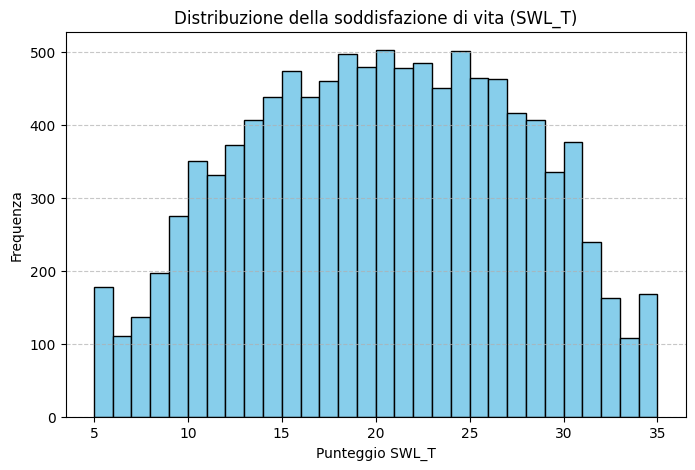

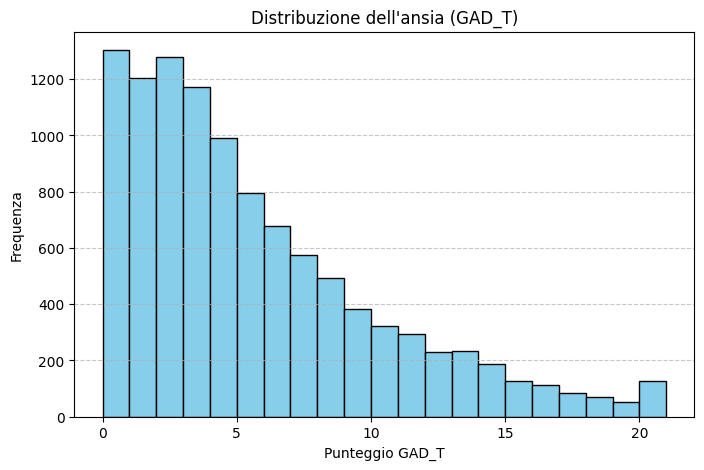

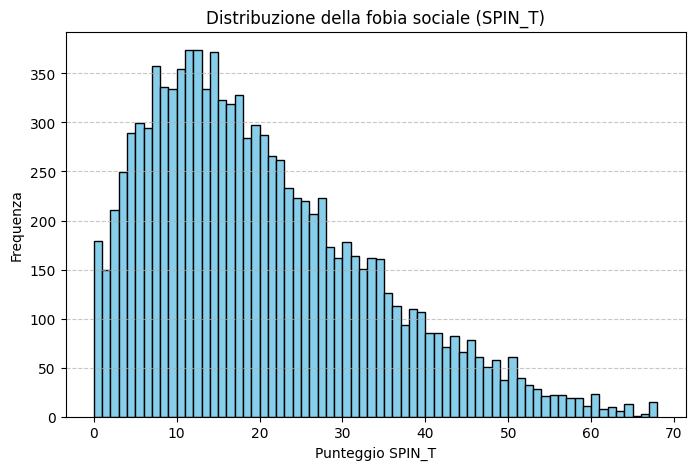

In [150]:
plt.figure(figsize=(8,5))   
plt.hist(lol_dataset['SWL_T'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione della soddisfazione di vita (SWL_T)')
plt.xlabel('Punteggio SWL_T')
plt.ylabel('Frequenza')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
plt.figure(figsize=(8,5))   
plt.hist(lol_dataset['GAD_T'], bins=21, color='skyblue', edgecolor='black')
plt.title('Distribuzione dell\'ansia (GAD_T)')
plt.xlabel('Punteggio GAD_T')
plt.ylabel('Frequenza')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
plt.figure(figsize=(8,5))   
plt.hist(lol_dataset['SPIN_T'], bins=68, color='skyblue', edgecolor='black')
plt.title('Distribuzione della fobia sociale (SPIN_T)')
plt.xlabel('Punteggio SPIN_T')
plt.ylabel('Frequenza')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

La variabile target SWL_T presenta una distribuzione approssimativamente normale, centrata intorno ai valori medi. Ciò suggerisce che il campione è bilanciato e che i modelli di regressione lineare sono appropriati per la predizione del livello di soddisfazione di vita.

Distribuzione delle League

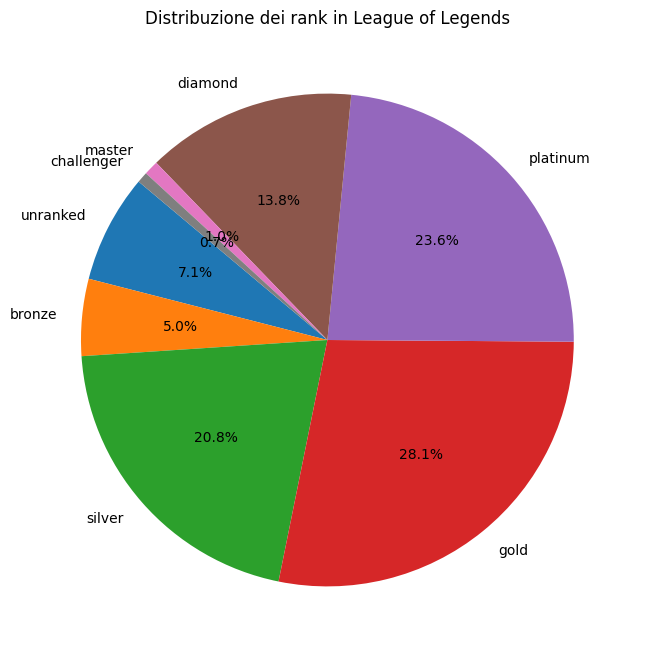

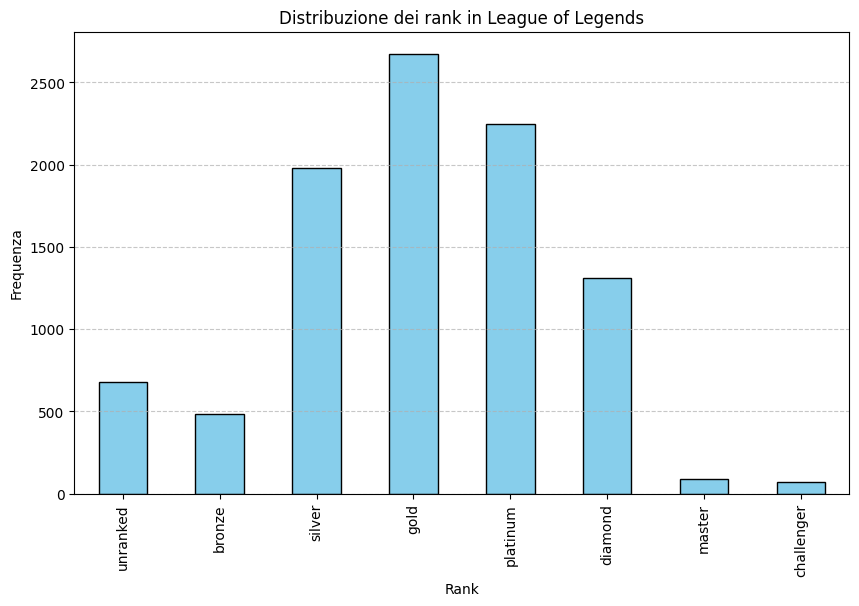

In [151]:
league_counts = lol_dataset['League'].value_counts().sort_index(key=lambda x: x.map(league_order))
league_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, figsize=(8,8))
plt.title('Distribuzione dei rank in League of Legends')
plt.ylabel('')
plt.show()
league_counts.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10,6))
plt.title('Distribuzione dei rank in League of Legends')
plt.xlabel('Rank')
plt.ylabel('Frequenza')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Il grafico mostra che i livelli di competitività più alti hanno meno frequenza e che in media i giocatori di questo dataset si trovano tra silver, gold e platinum.

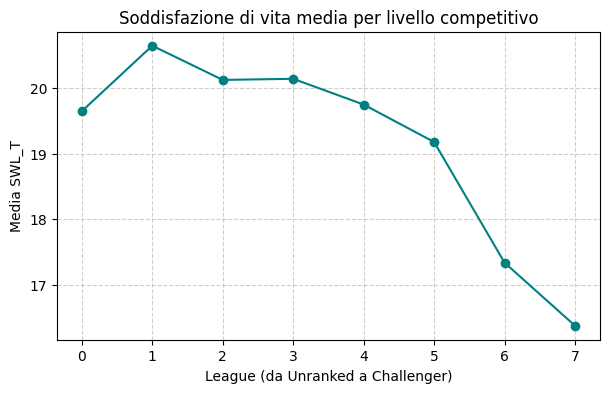

In [152]:
avg_swl = lol_dataset.groupby('League_num')['SWL_T'].mean()

plt.figure(figsize=(7,4))
plt.plot(avg_swl.index, avg_swl.values, marker='o', color='teal')
plt.title('Soddisfazione di vita media per livello competitivo')
plt.xlabel('League (da Unranked a Challenger)')
plt.ylabel('Media SWL_T')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Dal grafico si può notare che la soddisfazione di vita decresce all'aumentare del rank.

## Correlazioni

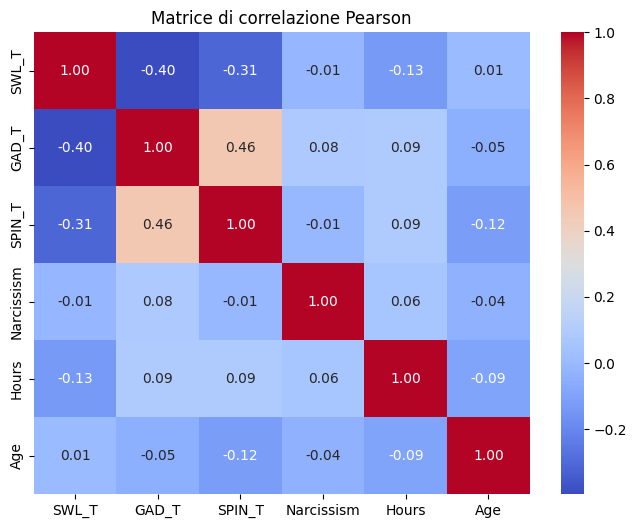

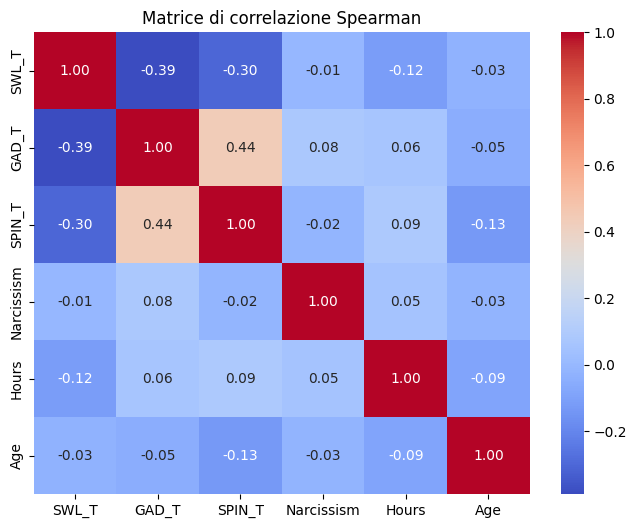

In [153]:
val = ['SWL_T', 'GAD_T', 'SPIN_T', 'Narcissism', 'Hours', 'Age']
corr_matrix = lol_dataset[val].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice di correlazione Pearson")
plt.show()
corr_matrix_spearman = lol_dataset[val].corr(method='spearman')
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix_spearman, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice di correlazione Spearman")
plt.show()

Dalla matrice di correlazione Pearson si può notare una correlazione negativa e moderata tra SWL_T (soddisfazione di vita) e SPIN_T, GAD_T. Invece si ha una correlazione negativa debole con le ore di gioco settimanali e quasi nulla per gli altri parametri.

# Modelli di regressione

### Preparazione
In questa fase vengono importate le librerie necessarie per la creazione dei modelli, viene effettuata la selezione delle variabili predittive e la standardizzazione di esse per la regressione lineare.

In [154]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Selezione delle variabili predittive
# Rimuovo colonne non numeriche o con troppe categorie
predictors = ['GAD_T', 'SPIN_T', 'Narcissism', 'Hours', 'Age', 'League_num', 
              'Degree_code', 'Work_code', 'GADE_code']

# Controllo la disponibilità delle colonne
available_predictors = [col for col in predictors if col in lol_dataset.columns]
print("Predittori disponibili:", available_predictors)

# Preparo i dati
X = lol_dataset[available_predictors].copy()
y = lol_dataset['SWL_T'].copy()

# Rimuovo righe con valori mancanti
before_na = len(X)
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]
print(f"Campioni dopo rimozione NA: {len(X)} (erano {before_na})")

# Split train/test
# Primo split -> 80% train, 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Secondo split -> 10% val, 10% test
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Training set: {len(X_train)}, Test set: {len(X_test)}, Validation set: {len(X_val)}")

# Standardizzazione per la regressione lineare
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

Predittori disponibili: ['GAD_T', 'SPIN_T', 'Narcissism', 'Hours', 'Age', 'League_num', 'Degree_code', 'Work_code', 'GADE_code']
Campioni dopo rimozione NA: 9524 (erano 10707)
Training set: 7619, Test set: 952, Validation set: 953


### Regressione Lineare

In [155]:
# MODELLO 1: Regressione Lineare
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predizioni
y_pred_lr_val = lr_model.predict(X_val_scaled)
y_pred_lr_test = lr_model.predict(X_test_scaled)

# Metriche per Regressione Lineare
print("=== REGRESSIONE LINEARE ===")
print(f"R² Validation: {r2_score(y_val, y_pred_lr_val):.4f}")
print(f"RMSE Validation: {np.sqrt(mean_squared_error(y_val, y_pred_lr_val)):.4f}")
print(f"MAE Validation: {mean_absolute_error(y_val, y_pred_lr_val):.4f}")

# Coefficienti
print("\nCoefficienti:")
coef_df = pd.DataFrame({
    'Feature': available_predictors,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)
print(coef_df)

=== REGRESSIONE LINEARE ===
R² Validation: 0.2509
RMSE Validation: 6.1512
MAE Validation: 5.0598

Coefficienti:
       Feature  Coefficient
0        GAD_T    -1.987258
7    Work_code    -1.140291
1       SPIN_T    -1.127506
4          Age    -0.608720
8    GADE_code    -0.558807
3        Hours    -0.493935
5   League_num    -0.201003
6  Degree_code    -0.163911
2   Narcissism     0.092276


### Random Forest

In [156]:
# MODELLO 2: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Predizioni
y_pred_rf_val = rf_model.predict(X_val)

# Metriche per Random Forest
print("\n=== RANDOM FOREST ===")
print(f"R² Validation: {r2_score(y_val, y_pred_rf_val):.4f}")
print(f"RMSE Validation: {np.sqrt(mean_squared_error(y_val, y_pred_rf_val)):.4f}")
print(f"MAE Validation: {mean_absolute_error(y_val, y_pred_rf_val):.4f}")

# Feature importance
print("\nImportanza delle variabili:")
importance_df = pd.DataFrame({
    'Feature': available_predictors,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(importance_df)


=== RANDOM FOREST ===
R² Validation: 0.2506
RMSE Validation: 6.1523
MAE Validation: 5.0432

Importanza delle variabili:
       Feature  Importance
0        GAD_T    0.355014
1       SPIN_T    0.157127
7    Work_code    0.120048
3        Hours    0.103065
4          Age    0.072745
8    GADE_code    0.063113
5   League_num    0.050435
2   Narcissism    0.041848
6  Degree_code    0.036606


### Gradient Boosting

#### GradientBoostingRegressor da sklearn.ensemble

In [157]:
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

# Predizioni
y_pred_gb_val = gb_model.predict(X_val)

r2_gb = r2_score(y_val, y_pred_gb_val)

# Metriche per Gradient Boosting
print("\n=== GRADIENT BOOSTING ===")
print(f"R² Validation: {r2_gb:.4f}")
print(f"RMSE Validation: {np.sqrt(mean_squared_error(y_val, y_pred_gb_val)):.4f}")
print(f"MAE Validation: {mean_absolute_error(y_val, y_pred_gb_val):.4f}")

# Feature importance
print("\nImportanza delle variabili (Gradient Boosting):")
importance_gb_df = pd.DataFrame({
    'Feature': available_predictors,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(importance_gb_df)


=== GRADIENT BOOSTING ===
R² Validation: 0.2575
RMSE Validation: 6.1238
MAE Validation: 4.9822

Importanza delle variabili (Gradient Boosting):
       Feature  Importance
0        GAD_T    0.400938
1       SPIN_T    0.148191
7    Work_code    0.134775
8    GADE_code    0.078330
3        Hours    0.077393
4          Age    0.063551
6  Degree_code    0.034994
5   League_num    0.032689
2   Narcissism    0.029139


#### XGBoost Regressor da xgboost

In [158]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# Predizioni
y_pred_xgb_val = xgb_model.predict(X_val)


r2_xgb = r2_score(y_val, y_pred_xgb_val)

# Metriche per XGBoost
print("\n=== XGBOOST ===")
print(f"R² Validation: {r2_xgb:.4f}")
print(f"RMSE Validation: {np.sqrt(mean_squared_error(y_val, y_pred_xgb_val)):.4f}")
print(f"MAE Validation: {mean_absolute_error(y_val, y_pred_xgb_val):.4f}")

# Feature importance
print("\nImportanza delle variabili (XGBoost):")
importance_xgb_df = pd.DataFrame({
    'Feature': available_predictors,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(importance_xgb_df)


=== XGBOOST ===
R² Validation: 0.2669
RMSE Validation: 6.0850
MAE Validation: 4.9483

Importanza delle variabili (XGBoost):
       Feature  Importance
0        GAD_T    0.282396
7    Work_code    0.251240
8    GADE_code    0.136988
1       SPIN_T    0.074831
6  Degree_code    0.063134
4          Age    0.050887
3        Hours    0.049668
2   Narcissism    0.047539
5   League_num    0.043318


#### Confronto
Tra i due modelli vediamo che XGBoost ha una performance migliore

In [159]:
pct_change = ((r2_xgb - r2_gb) / abs(r2_gb)) * 100 if r2_gb != 0 else float('inf')
print(f"R² Validation XGBoost: {r2_xgb:.4f}")
print(f"R² Validation Gradient Boosting: {r2_gb:.4f}")
print(f"\nVariazione percentuale di R² tra XGBoost e Gradient Boosting: {pct_change:.2f}%")

R² Validation XGBoost: 0.2669
R² Validation Gradient Boosting: 0.2575

Variazione percentuale di R² tra XGBoost e Gradient Boosting: 3.64%


# Ricerca degli iperparametri

In [160]:
from sklearn.model_selection import GridSearchCV

### Random Forest

In [162]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

print("Migliori iperparametri per Random Forest:", grid_search_rf.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Migliori iperparametri per Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}


In [163]:
best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_val)

print("\n=== Random Forest Ottimizzato Validation set ===")
print(f"R² Validation: {r2_score(y_val, y_pred_best_rf):.4f}")
print(f"RMSE Validation: {np.sqrt(mean_squared_error(y_val, y_pred_best_rf)):.4f}")
print(f"MAE Validation: {mean_absolute_error(y_val, y_pred_best_rf):.4f}")


=== Random Forest Ottimizzato Validation set ===
R² Validation: 0.2531
RMSE Validation: 6.1419
MAE Validation: 5.0277


In [164]:
y_pred_best_rf_test = best_rf.predict(X_test)
print("\n=== Random Forest Ottimizzato Test set ===")
print(f"R² Test: {r2_score(y_test, y_pred_best_rf_test):.4f}")
print(f"RMSE Test: {np.sqrt(mean_squared_error(y_test, y_pred_best_rf_test)):.4f}")
print(f"MAE Test: {mean_absolute_error(y_test, y_pred_best_rf_test):.4f}")


=== Random Forest Ottimizzato Test set ===
R² Test: 0.2388
RMSE Test: 6.1975
MAE Test: 5.0775


### XGBoost

In [165]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.005, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)

print("Migliori iperparametri per XGBoost:", grid_search_xgb.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Migliori iperparametri per XGBoost: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


In [166]:
best_xgb = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_val)

print("\n=== XGBOOST Ottimizzato Validation set ===")
print(f"R² Validation: {r2_score(y_val, y_pred_best_xgb):.4f}")
print(f"RMSE Validation: {np.sqrt(mean_squared_error(y_val, y_pred_best_xgb)):.4f}")
print(f"MAE Validation: {mean_absolute_error(y_val, y_pred_best_xgb):.4f}")


=== XGBOOST Ottimizzato Validation set ===
R² Validation: 0.2760
RMSE Validation: 6.0472
MAE Validation: 4.9420


In [167]:
y_pred_best_xgb_test = best_xgb.predict(X_test)

print("\n=== XGBOOST Ottimizzato Test set ===")
print(f"R² Test: {r2_score(y_test, y_pred_best_xgb_test):.4f}")
print(f"RMSE Test: {np.sqrt(mean_squared_error(y_test, y_pred_best_xgb_test)):.4f}")
print(f"MAE Test: {mean_absolute_error(y_test, y_pred_best_xgb_test):.4f}")


=== XGBOOST Ottimizzato Test set ===
R² Test: 0.2728
RMSE Test: 6.0575
MAE Test: 4.9650


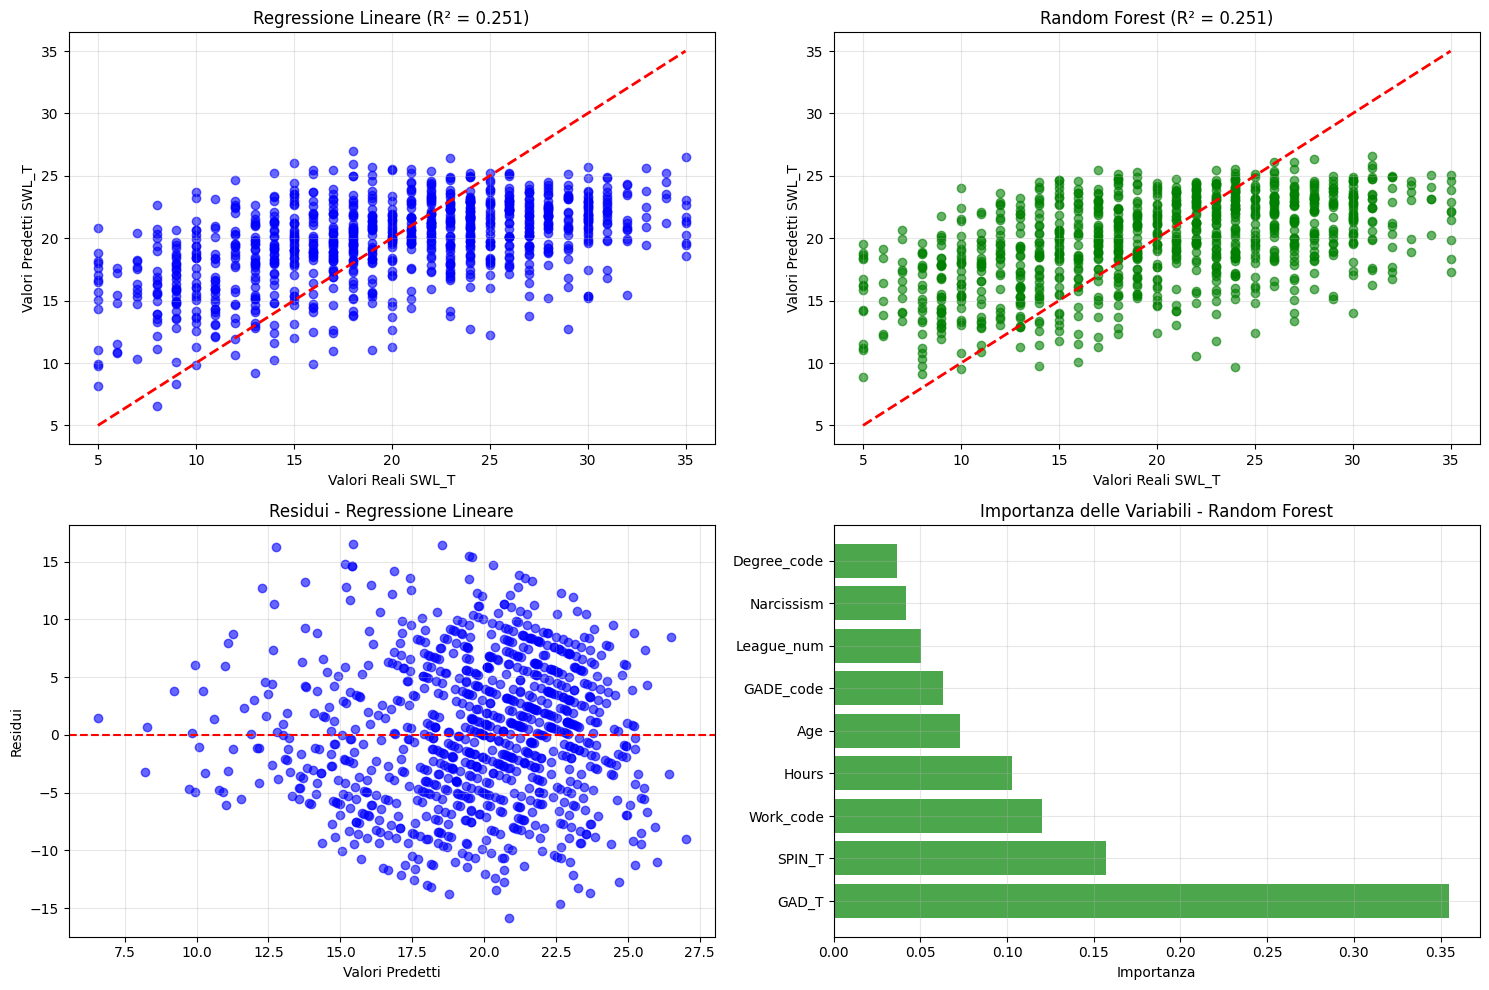

In [168]:
# Visualizzazione dei risultati
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Valori predetti vs valori reali - Regressione Lineare
axes[0,0].scatter(y_val, y_pred_lr_val, alpha=0.6, color='blue')
axes[0,0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Valori Reali SWL_T')
axes[0,0].set_ylabel('Valori Predetti SWL_T')
axes[0,0].set_title(f'Regressione Lineare (R² = {r2_score(y_val, y_pred_lr_val):.3f})')
axes[0,0].grid(True, alpha=0.3)

# 2. Valori predetti vs valori reali - Random Forest
axes[0,1].scatter(y_val, y_pred_rf_val, alpha=0.6, color='green')
axes[0,1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Valori Reali SWL_T')
axes[0,1].set_ylabel('Valori Predetti SWL_T')
axes[0,1].set_title(f'Random Forest (R² = {r2_score(y_val, y_pred_rf_val):.3f})')
axes[0,1].grid(True, alpha=0.3)

# 3. Residui - Regressione Lineare
residuals_lr = y_val - y_pred_lr_val
axes[1,0].scatter(y_pred_lr_val, residuals_lr, alpha=0.6, color='blue')
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].set_xlabel('Valori Predetti')
axes[1,0].set_ylabel('Residui')
axes[1,0].set_title('Residui - Regressione Lineare')
axes[1,0].grid(True, alpha=0.3)

# 4. Feature Importance - Random Forest
importance_df_plot = importance_df
axes[1,1].barh(importance_df_plot['Feature'], importance_df_plot['Importance'], color='green', alpha=0.7)
axes[1,1].set_xlabel('Importanza')
axes[1,1].set_title('Importanza delle Variabili - Random Forest')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

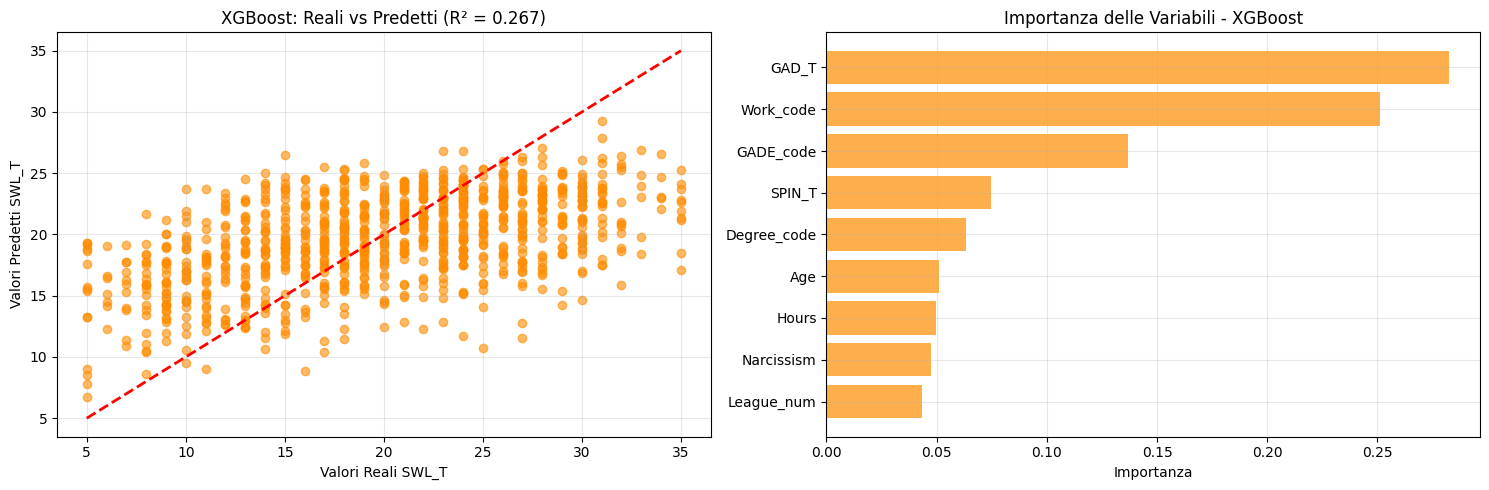

In [169]:
# Grafici XGBoost: Valori reali vs predetti e Importanza variabili
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1) Valori predetti vs reali - XGBoost
axes[0].scatter(y_val, y_pred_xgb_val, alpha=0.6, color='darkorange')
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0].set_xlabel('Valori Reali SWL_T')
axes[0].set_ylabel('Valori Predetti SWL_T')
axes[0].set_title(f'XGBoost: Reali vs Predetti (R² = {r2_score(y_val, y_pred_xgb_val):.3f})')
axes[0].grid(True, alpha=0.3)

# 2) Importanza delle variabili - XGBoost
importance_xgb_plot = importance_xgb_df
axes[1].barh(importance_xgb_plot['Feature'], importance_xgb_plot['Importance'], color='darkorange', alpha=0.7)
axes[1].invert_yaxis()  # feature più importanti in alto
axes[1].set_xlabel('Importanza')
axes[1].set_title('Importanza delle Variabili - XGBoost')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Interpretazione dei risultati

**Modelli implementati:**
1. **Regressione Lineare**: modello lineare semplice con standardizzazione delle variabili
2. **Random Forest**: ensemble di alberi decisionali per catturare relazioni non lineari

**Variabili predittive utilizzate:**
- Fattori psicologici: GAD_T (ansia), SPIN_T (fobia sociale), Narcissism
- Comportamento di gioco: Hours (ore settimanali), League_num (livello competitivo)
- Demografiche: Age, Degree_code, Work_code, GADE_code

**Metriche di valutazione:**
- **R²**: coefficiente di determinazione (varianza spiegata dal modello)
- **RMSE**: errore quadratico medio (in unità di SWL_T)
- **MAE**: errore assoluto medio

**Analisi dei grafici:**
- I grafici scatter mostrano la correlazione tra valori predetti e reali
- I residui dovrebbero essere distribuiti casualmente intorno allo zero
- L'importanza delle variabili nel Random Forest indica quali fattori influenzano maggiormente la soddisfazione di vita

# Riferimenti bibliografici

- OSF. (2017). Gaming Study Dataset [Dataset]. OSF. https://osf.io/vnbxk

- Oparina, E., Kaiser, C., Gentile, N. et al. Machine learning in the prediction of human wellbeing. Sci Rep 15, 1632 (2025). https://doi.org/10.1038/s41598-024-84137-1
